In [1]:
import numpy as np
import torch
import torch.nn as nn

from IPython.display import clear_output

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as T

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [2]:
# nets
from autoencoders import StackedAutoEncoder, StackedDenoisingAutoEncoder
from deepclustering import DEC, IDEC, IDEC_loss
from utils import cluster_acc # hungarian algorithm

# dataset&train_cycles
from train_val_cycles import train, evaluate

# visualization
from visualization import plot_stats, plot_stats_dec, plot_stats_idec


## Dataset

In [3]:
mnist_transforms = T.Compose(
    [
        T.Resize((28, 28)),
        T.ToTensor(),
    ]
)

train_dataset = MNIST('mnist', train=True, transform=mnist_transforms, download=True)
valid_dataset = MNIST('mnist', train=False, transform=mnist_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=0, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=0, pin_memory=True)
static_loader =  DataLoader(train_dataset, batch_size=256, pin_memory=False, shuffle=False)

## Train&Valid

In [4]:
def whole_train_valid_cycle(
    model, scheduler, optimizer, loss_fn, device, title,
    num_epochs:int = 100, 
    patience_threshold:tuple = None,
    save_best_params_as:str = None
):
    train_loss_history, valid_loss_history = [], []
    
    best_valid_loss = np.inf
    patience = 0

    train_acc_history, train_nmi_history, train_ari_history = [], [], []
    val_acc_history, val_nmi_history, val_ari_history = [], [], []
    
    if type(model) == IDEC:
        train_rec_loss_history, train_cl_loss_history = [], []

    for epoch in range(num_epochs):

        if isinstance(model, DEC):

            train_loss, train_y, train_y_pred, = train(model, train_loader, optimizer, loss_fn, device, static_loader)
            valid_loss, val_targets, val_predicted = evaluate(model, valid_loader, loss_fn, device)
            
            if type(model) == IDEC:

                train_rec_loss, train_cl_loss = train_loss['rec'], train_loss['clust']
                train_loss = train_loss['total']
                
                
                train_rec_loss_history.append(train_rec_loss)
                train_cl_loss_history.append(train_cl_loss)
                

            train_acc = cluster_acc(train_y, train_y_pred)
            train_nmi = normalized_mutual_info_score(train_y, train_y_pred)
            train_ari = adjusted_rand_score(train_y, train_y_pred)

            train_acc_history.append(train_acc)
            train_nmi_history.append(train_nmi)
            train_ari_history.append(train_ari)

            val_acc = cluster_acc(val_targets, val_predicted)
            val_nmi = normalized_mutual_info_score(val_targets, val_predicted)
            val_ari = adjusted_rand_score(val_targets, val_predicted)

            val_acc_history.append(val_acc)
            val_nmi_history.append(val_nmi)
            val_ari_history.append(val_ari)
        
 
        elif isinstance(model, StackedAutoEncoder):
            train_loss = train(model, train_loader, optimizer, loss_fn, device)
            valid_loss = evaluate(model, valid_loader, loss_fn, device)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)
        
        print('patience:', patience)
        if patience_threshold[0] is not None and len(valid_loss_history)>1:
            if round(valid_loss_history[-2], patience_threshold[1]) \
            == round(valid_loss, patience_threshold[1]):
                patience += 1
            else:
                patience = 0

            if patience == patience_threshold[0]:
                print('Training stopped. Patience threshold was reached')
                break


        clear_output(wait=True)
        

        if isinstance(model, DEC):
            if type(model) == DEC:
                plot_stats_dec(
                    train_loss_history, valid_loss_history, 
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )
            if type(model) == IDEC:
                plot_stats_idec(
                    train_loss_history, valid_loss_history, 
                    train_rec_loss_history, 
                    train_cl_loss_history,
                    train_acc_history, train_nmi_history, train_ari_history,
                    val_acc_history, val_nmi_history, val_ari_history,
                    title,
                )

        elif isinstance(model, StackedAutoEncoder):
            plot_stats(
                train_loss_history, valid_loss_history,
                title
            )

            # scheduler only for autoencoder
            scheduler.step() if not scheduler == None else None


        if not save_best_params_as == None:
            if valid_loss < best_valid_loss: 
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), save_best_params_as)
                print(f"Model parameters saved to '{save_best_params_as}'")                  
        
        

## Initialize

In [5]:
#!g1.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
print(torch.cuda.get_device_name())

cuda:0
NVIDIA GeForce GTX 1060 with Max-Q Design


## Run Autoencoder

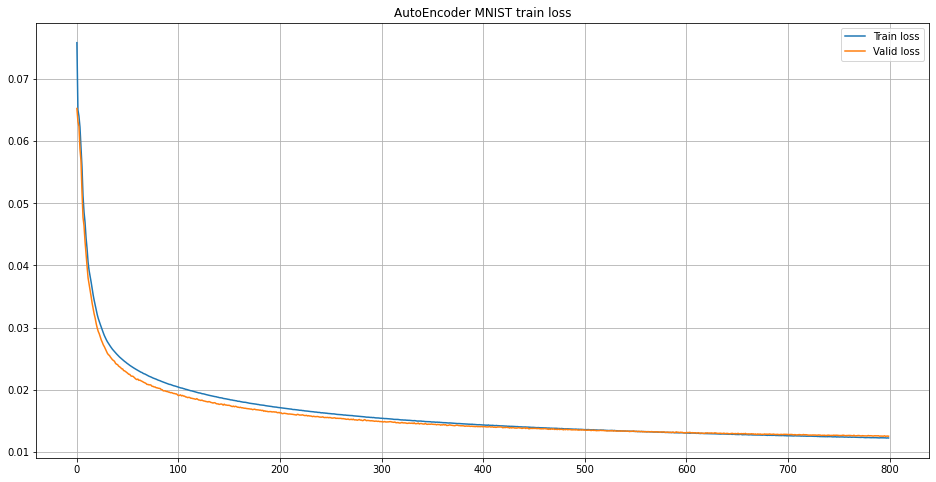

In [ ]:
loss_fn = nn.MSELoss()
model = StackedDenoisingAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.002)

# optimizer = Adam(model.parameters(), lr=1e-3)
optimizer = SGD(model.parameters(), lr=0.1, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=200, gamma=0.1) # 60~=20000/256


whole_train_valid_cycle(
    model, 
    None,
    optimizer,
    loss_fn,
    num_epochs = 800, 
    device = device,
    patience_threshold = (10,5), # (epochs, rounded_loss)
    # save_best_params_as = r'.\weights\autoencoder_weights.pt',
    title='AutoEncoder MNIST train'
)

Best obtained weights saved to '_autoencoder_weights_mnist_drop002.pt'

## Run DEC

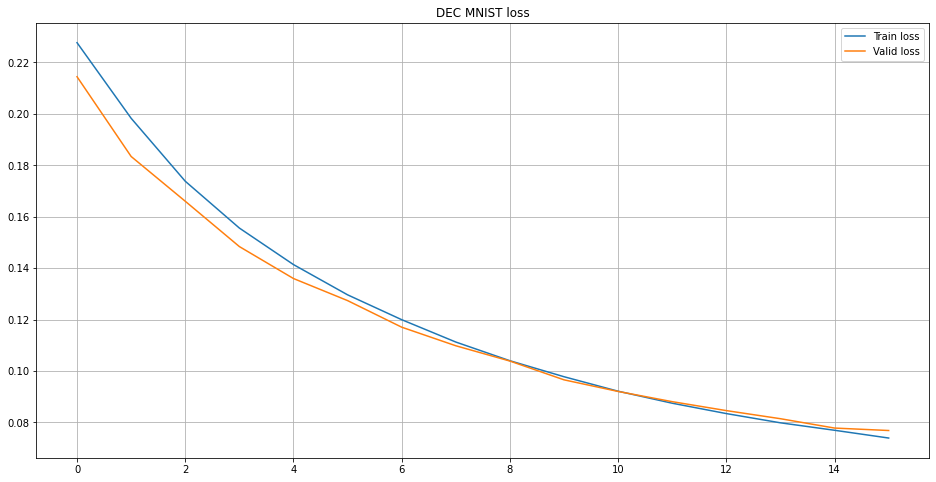

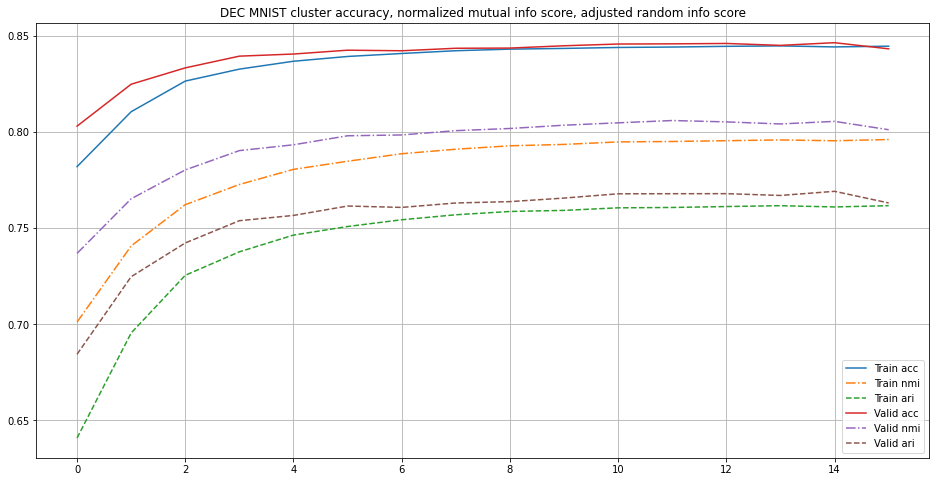

In [6]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.0)

model.load_state_dict(torch.load(r'.\weights\_autoencoder_weights_mnist_drop002.pt'))


dec = DEC(autoencoder = model)
loss_fn = nn.KLDivLoss(reduction='batchmean')

# optimizer = Adam(dec.parameters(), lr=1e-4)
optimizer = SGD(dec.parameters(), lr=.01, momentum=0.9)

whole_train_valid_cycle(
    dec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 16,
    patience_threshold = (10,5),
    # save_best_params_as = '.\weights\dec_weights.pt',
    device = device,
    title='DEC MNIST'
)


Weights saved to '_dec_weights_acc85.pt'

In [7]:
print(
    dec.init_acc,
cluster_acc(
    train_dataset.targets.numpy(),
    dec(train_dataset.data.reshape(-1, 784).to(device, dtype=torch.float32)).argmax(1).detach().cpu().numpy()
)
)

0.7716333333333333 0.8499


## Run IDEC

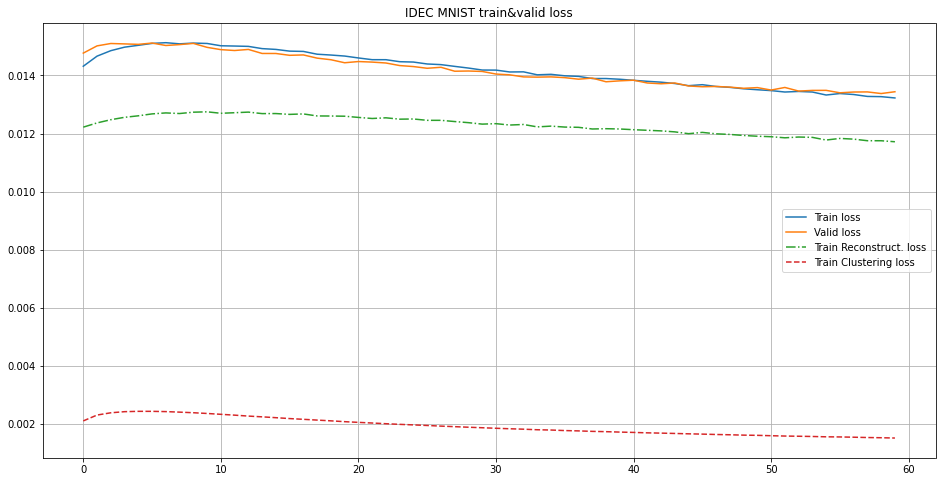

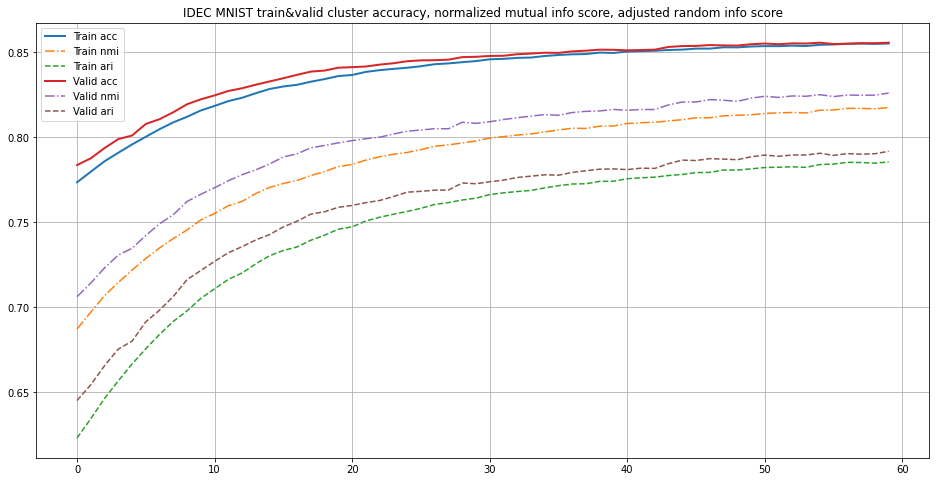

In [ ]:
model = StackedAutoEncoder(dims=[784, 500, 500, 2000, 10], dropout_value=.002)

model.load_state_dict(torch.load(r'.\weights\_autoencoder_weights_mnist_drop002.pt'))

idec = IDEC(autoencoder=model)
loss_fn = IDEC_loss(gamma=1e-2)

optimizer = Adam(idec.parameters(), lr=1e-4,  betas = (.9, .999))
# optimizer = SGD(idec.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=4, gamma=0.1)

whole_train_valid_cycle(
    idec,
    None,
    optimizer,
    loss_fn,
    num_epochs = 60,
    patience_threshold = (10,5),
    # save_best_params_as = 'idec_weights.pt',
    device=device,
    title='IDEC MNIST train&valid'
)

Weights saved to '_idec_weights_acc85.pt'. Possibly there are some discussion about tuning losses of IDEC

In [ ]:
print(
    idec.init_acc,
    cluster_acc(
    train_dataset.targets.numpy(),
    idec(train_dataset.data.reshape(-1, 784).to(device, dtype=torch.float32))[0].argmax(1).detach().cpu().numpy()
))

0.7711 0.8546333333333334
